# [SITCOM-1116] - Settling Time After a Slew

2023-11-23 Nacho, HyeYun, Peter

Notebook containing data analysis for the [LVV-T11258] test case. 

This notebook will return a settling time. 

Method: We will measure the RMS of the displacement values with respect to a long term value of positions and rotations measured by the IMS at M1M3 which shouldn't exceed the IMS repeatability error in 2 sec time range after the slew stop. We will determine the "settle" to be the point where the big vibrations stop.

[LVV-T11258]: https://jira.lsstcorp.org/browse/LVV-11258

### Prepare Notebook

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimezoneInfo
from statsmodels.tsa.stattools import adfuller

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient

import warnings
warnings.filterwarnings('ignore')

In [3]:
# create a client to retrieve datasets in the EFD database
client = makeEfdClient()

### Define relevant settings

#### Requirements

In [4]:
req_delta_t = 3 ## seconds after slew
req_rms_position = 2e-3 ## mm, tolerance from repeatability requirement for IMS positional
req_rms_rotation = 3e-5 ## degrees, tolerance from repeatability requirement for IMS rotational

#### Observation day

In [5]:
dayObs =   20230627 # 3.5 degree slews #2023071 #20230710 contains the first large slew motions

#### Get slew stops

In [6]:
# Select data from a given date
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type==TMAState.SLEWING]
tracks = [e for e in events if e.type==TMAState.TRACKING]
print(f'Found {len(slews)} slews and {len(tracks)} tracks')

Found 486 slews and 0 tracks


#### Define specific slew, and maximum time after event for calculations and plots 

In [7]:
# define specific slew
i_slew = 450 
# define time padding after end of slew
postPadding = 15 # in seconds

### Define functions

#### determine settling time

This is the function that will return a PASS/FAIL depending on whether the RMS with respect to the end of the measurement window is smaller than requirement within the time window.

In [8]:
def determineSettleTime(df_ims, #input data frame
                        reference_t = '2023-06-01T06:00:0Z', #time for slew stop
                        lo_delta_t = 5, #in seconds
                        hi_delta_t = 30, #in seconds
                        imsColumn = 'xPosition', #IMS column
                        rmsReq = 2e-3, #requirement in appropriate units
                        req_delta_t = 3, #time for settling, in seconds
                        lapse = 200, pvalue = 0.05): #for ADF test, currently not used
    
    #repeatability requirements are 2 microns in position and 30 microdegs in rotation
    if 'Position' in imsColumn:
        units = 'mm'
        ylimMax = rmsReq + 0.001
    elif 'Rotation' in imsColumn:
        units = 'deg'
        print(rmsReq)
        ylimMax = rmsReq + 0.0001
    else:
        print('Unidentified column')
        return -1

    #T0 and T1 defines the window for requirement to be met
    T0 = pd.to_datetime(reference_t)
    T1 = T0 + pd.to_timedelta(req_delta_t,unit='s')
    # delta_window is the time window for plot and reference for mean, before and after T0
    delta_window = [pd.Timedelta(lo_delta_t, "seconds"),pd.Timedelta(hi_delta_t, "seconds")] 
    #zoom around the T0 of interest
    TZoom = [T0-delta_window[0],  T0+delta_window[1]] 
      
    targetVariablePlot = df_ims[imsColumn][TZoom[0]:TZoom[1]] #complete plot range
    targetVariableWindow = df_ims[imsColumn][T0:T1] #from slew stop to end of req. window
    idxT0 = df_ims.index[df_ims.index.get_indexer([pd.to_datetime(T0)], method='nearest')]
    idxT1 = df_ims.index[df_ims.index.get_indexer([pd.to_datetime(T1)], method='nearest')]
    idxTend = df_ims.index[df_ims.index.get_indexer([pd.to_datetime(T0+delta_window[1])], method='nearest')]
    targetVariableReference = [df_ims[imsColumn][idxT0],float(df_ims[imsColumn][idxTend])] 
    #at slew stop and end of plot
    #print('At T1',df_ims[imsColumn][idxT1].get_indexer())
    
    if len(targetVariablePlot.index) == 0:
        print('Data frame is empty')
        return -1
    
    #rms of difference wrt to end of plot, of values within requirement in window
    #it is important that the end of the plot (targetVariableReference) does not hit another 
    #slew or movement, nor at any point in the middle of the window
    rms = np.std(targetVariableWindow-targetVariableReference[1]) 
    
    title = imsColumn
    label = imsColumn + '(' + units +') wrt value at slew stop'

    fig = plt.figure()
    plt.plot(targetVariablePlot-targetVariableReference[0][0],
             color='red', lw="0.5", label=label)
    plt.axvline(T0, lw="1.25", c="k", ls="dashed", label='Slew stop')
    plt.axhline(-rmsReq, lw="0.75", c="k", ls="dashed", label='IMS repeatability req.')
    plt.axhline(rmsReq, lw="0.75", c="k", ls="dashed")
    plt.xlabel("Time [UTC]")
    plt.ylabel(label)
    plt.text(0.25, 0.92, 'RMS =' + ' {:.2e} '.format(rms) + units + 
             ' in 3s window, wrt value at end of plot', 
             transform=fig.transFigure)
    fig.autofmt_xdate()
    fig.tight_layout()

    ## recomputing RMS for the whole range since T0
    rolling = 20
    targetVariable = df_ims[imsColumn][T0:TZoom[1]]
    rms = (targetVariable - targetVariableReference[1]).rolling(rolling).std()
    plt.plot(rms, label='RMS wrt value at the end of plot,\n from slew stop')
    plt.axvspan(T0, T1, alpha=0.5, color='green', label='3s tolerance window')
    plt.legend(loc="upper right", fontsize = "8")
    #print(rms) 

    fig = plt.figure()    
    rms = rms.dropna() # remove NaNs created by the rolling function

    ## compute time for settling using the Augmented Dickey-Fuller test
    ## in this test, if you discard the null hypothesis, stationarity is found
    ## https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test
    k= 0
    for i in range(0,len(rms)-lapse):# lapse is the number of forward events that are used for
                                     # the RMS to measure stationarity 
        adf = adfuller(rms[i:i+lapse], autolag='AIC')
        #print(i,rms.index[i],adf[1],len(rms)-lapse)
        if adf[1] < pvalue: # is non-stationary if null hypothesis is true (large p-value)
            #print(i, i+lapse, adf[1], pvalue)
            k = i+lapse #stationarity is reached at the time stamp at the end of the lapse 
                        #used for RMS
            #print(k, rms.index[k])
            break
    
    iT1 = 105 ## have to find a way to get this number, corresponding to idxT1
    plt.plot(rms[0:iT1]) 
    print("index at T1",iT1)
    plt.axvline(T0, lw="1.25", c="k", ls="dashed", label='Slew stop')
    #plt.axvline(rms.index[k], lw="1.25", c="green", ls="dashed", label='Settled')
    plt.axvspan(T0, T1, alpha=0.5, color='green', label='3s tolerance window')
    plt.axhline(rmsReq, lw="0.75", c="k", ls="dashed", label='IMS repeatability req.')
    plt.xlabel("Time [UTC]")
    plt.ylabel('RMS wrt value at the end of plot ('+units+')')
    plt.ylim(-1e-4,ylimMax)
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.text(0.50, 0.93, 'Slew stop =' + t1.strftime('%H:%M:%S.%f'), transform=fig.transFigure)        
    #plt.text(0.50, 0.90, 'Settling time (ADF test) =' + rms.index[k].strftime('%H:%M:%S.%f'), transform=fig.transFigure)        
    #time_to_settle = rms.index[k]-t1
    #print("Time to settle:",lapse,k,time_to_settle.total_seconds(),"s")
    #for i in range(0,len(rms)):
    #    print(i,rms[i])
    if all(x < rmsReq for x in rms[0:iT1]):
        print('Test PASSED')
        return True
    else:
        print('Test FAILED')
        failedVals = [x for x in rms[0:iT1] if x >= rmsReq]
        print(failedVals)
        return False
    
    #return rms.index[k]
    
    

#### compare IMS vs mount data

This is an auxiliary function to plot information from the IMS with respect to the elevation and azimuth measurements from the mount.

In [9]:
def compareIMSMount(df_ims,
                   df_mtmount_ele,
                   df_mtmount_azi,
                   reference_t = '2023-06-01 06:53:37.326',
                   lo_delta_t = 5, #in seconds
                   hi_delta_t = 60): #in seconds
    
    fig,axs = plt.subplots(5,1, dpi=125, figsize=(6,8))
    t_start_plot = pd.to_datetime(reference_t) - pd.to_timedelta(lo_delta_t,unit='s') ##correcting by hand for TAI, is this correct?
    t_end_plot = pd.to_datetime(reference_t) + pd.to_timedelta(hi_delta_t,unit='s')

    ax = axs[0]
    actpos_ele = df_mtmount_ele['actualPosition'][t_start_plot:t_end_plot]
    ax.plot(actpos_ele,color='red', lw="0.5")
    ax.axvline(pd.to_datetime(reference_t), lw="0.5", c="k")
    ax.set_ylabel("Elevation \nPosition\n[deg]")
    
    ax = axs[1]
    actpos_azi = df_mtmount_azi['actualPosition'][t_start_plot:t_end_plot]
    ax.plot(actpos_azi,color='red', lw="0.5")
    ax.axvline(pd.to_datetime(reference_t), lw="0.5", c="k")
    ax.set_ylabel("Azimuth \nPosition\n[deg]")

    t_start_plot = pd.to_datetime(reference_t) - pd.to_timedelta(lo_delta_t,unit='s') 
    t_end_plot = pd.to_datetime(reference_t) + pd.to_timedelta(hi_delta_t,unit='s')
    
    plotstring = ['xPosition','yPosition','zPosition']
    plotrange = np.arange(len(plotstring))    
    for i in plotrange:
        ax = axs[i+2]
        pos = df_ims[plotstring[i]][t_start_plot:t_end_plot]
        ax.plot(pos,color='red', lw="0.5")
        ax.axvline(pd.to_datetime(reference_t), lw="0.5", c="k")
        ax.set_ylabel(plotstring[i] + ' \n[mm]')
    ax.set_xlabel('UTC')
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=1)
    fig.suptitle(reference_t)
    fig.tight_layout()
    ### TBD: use a delta time wrt slew stop in x-label

### Load data

In [10]:
all_columns = ["xPosition", "xRotation", "yPosition", "yRotation", "zPosition", "zRotation"]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]

In [11]:
t0 = Time(slews[i_slew].begin, format='isot', scale='utc')
t0 = pd.to_datetime(t0.value, utc=True) # astropy Time to Timestamp conversion
t1 = Time(slews[i_slew].end, format='isot', scale='utc')
t1 = pd.to_datetime(t1.value, utc=True) # astropy Time to Timestamp conversion
print('Slew stop at:',t1)

# Get IMS data
# Note that we need data beyond the associated to the slew stop, 
# which just covers the slew itself, ie, while the telescope is moving (TBC)
df_ims = getEfdData(client, 'lsst.sal.MTM1M3.imsData', 
                    event=slews[i_slew], 
                    postPadding = postPadding)
df_ims = df_ims[all_columns]
# Convert meter to milimeter 
df_ims[pos_columns] = df_ims[pos_columns] * 1e3

Slew stop at: 2023-06-28 08:52:35.505000+00:00


In [12]:
# Get mount data
df_mtmount_ele = getEfdData(client,'lsst.sal.MTMount.elevation', 
                            event=slews[i_slew], 
                            postPadding = postPadding)
df_mtmount_azi = getEfdData(client,'lsst.sal.MTMount.azimuth', 
                            event=slews[i_slew], 
                            postPadding = postPadding)

### Look at data

This is step is not necessary, but useful to get a visual impression of how the IMS data vary with TMA movements.

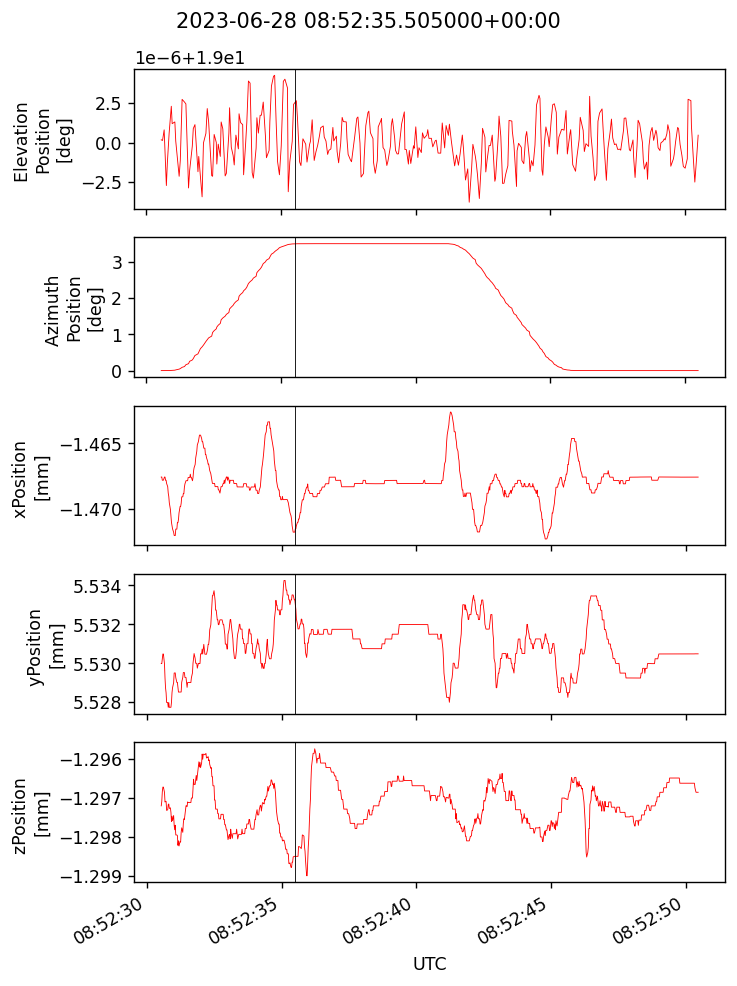

In [13]:
%matplotlib inline
compareIMSMount(df_ims,df_mtmount_ele,df_mtmount_azi,
                t1,10,pd.to_timedelta(postPadding, unit="s"))

### Run test

Currently the test involves executing the determineSettleTime function, an example is shown below. The test will return a PASS if the rms of the fluctuation of the variable around the value at the end of the set window (set at postPadding above) is always below the requirement, in the required time after the slew stop event. Two plots are shown, the first showing the value and RMS, until the end of the window, the second zooming in on the requirement time period.

index at T1 105
Test PASSED


True

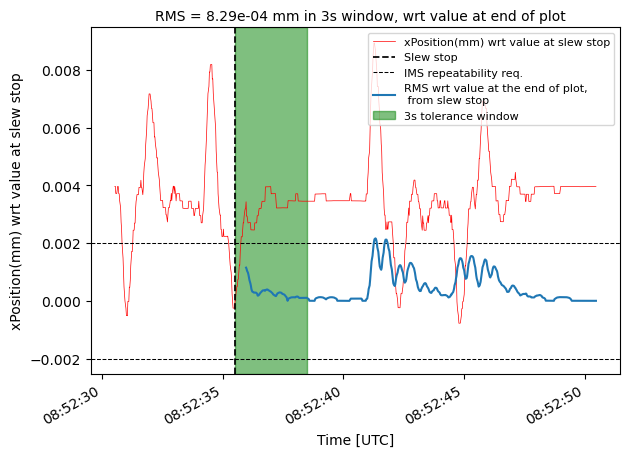

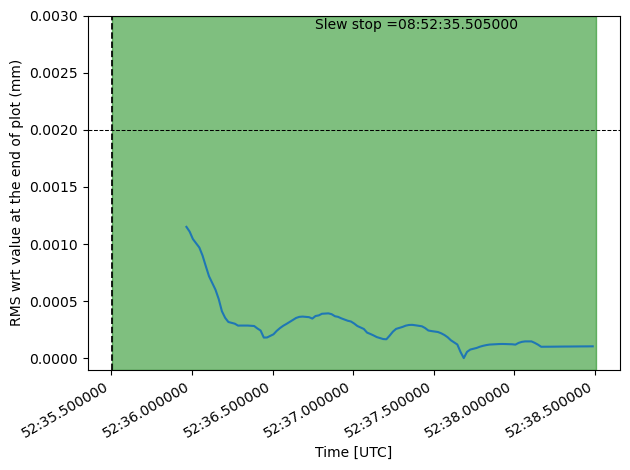

In [14]:
%matplotlib inline
determineSettleTime(df_ims = df_ims, 
                    reference_t = t1, 
                    lo_delta_t = 5,
                    hi_delta_t = postPadding,
                    imsColumn = 'xPosition', 
                    rmsReq = req_rms_position, 
                    req_delta_t = req_delta_t,
                    lapse = 600, pvalue = 0.001)

3e-05
index at T1 105
Test FAILED
[3.035051245593053e-05, 3.059588664636329e-05, 3.0395112645642247e-05]


False

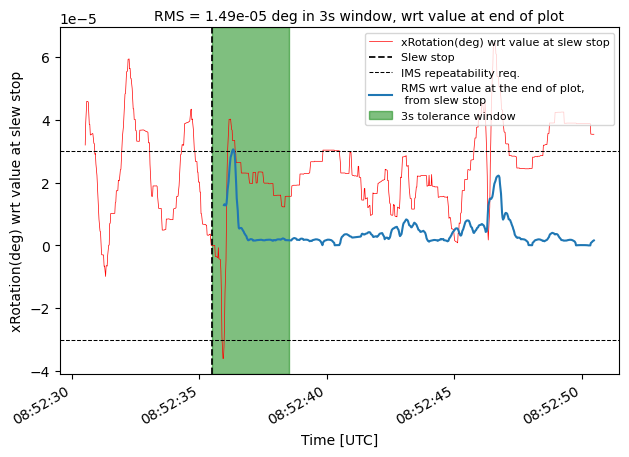

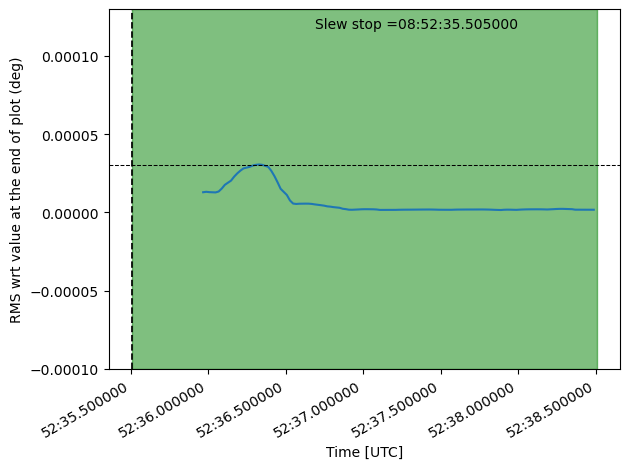

In [15]:
%matplotlib inline
determineSettleTime(df_ims = df_ims, 
                    reference_t = t1, 
                    lo_delta_t = 5,
                    hi_delta_t = postPadding,
                    imsColumn = 'xRotation', 
                    rmsReq = req_rms_rotation, 
                    req_delta_t = req_delta_t,
                    lapse = 600, pvalue = 0.001)

3e-05
index at T1 105
Test PASSED


True

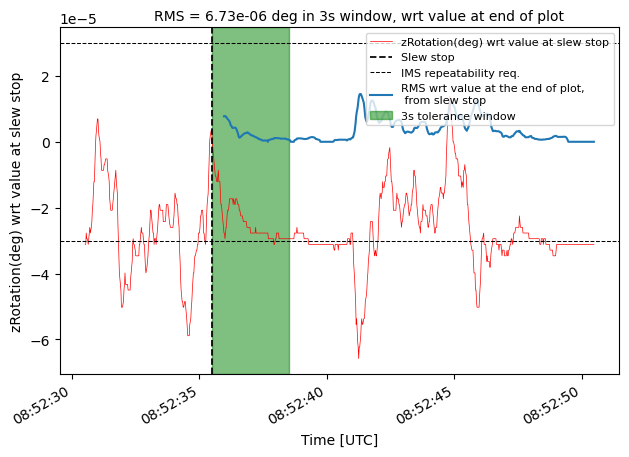

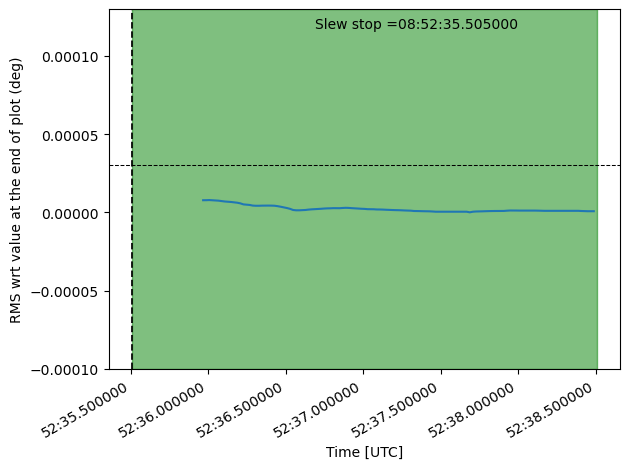

In [20]:
%matplotlib inline
determineSettleTime(df_ims = df_ims, 
                    reference_t = t1, 
                    lo_delta_t = 5,
                    hi_delta_t = postPadding,
                    imsColumn = 'zRotation', 
                    rmsReq = req_rms_rotation, 
                    req_delta_t = req_delta_t,
                    lapse = 600, pvalue = 0.001)

index at T1 105
Test PASSED


True

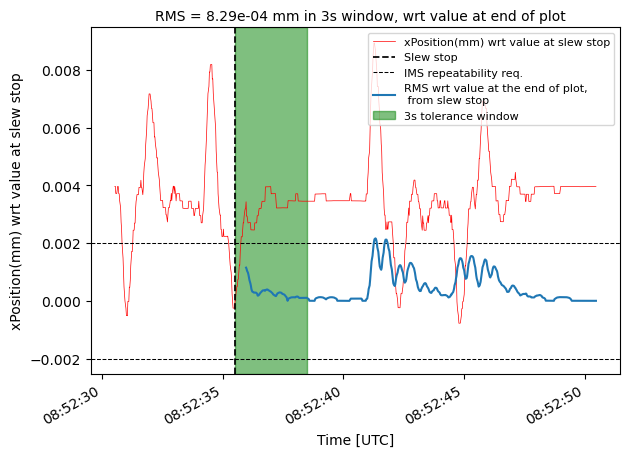

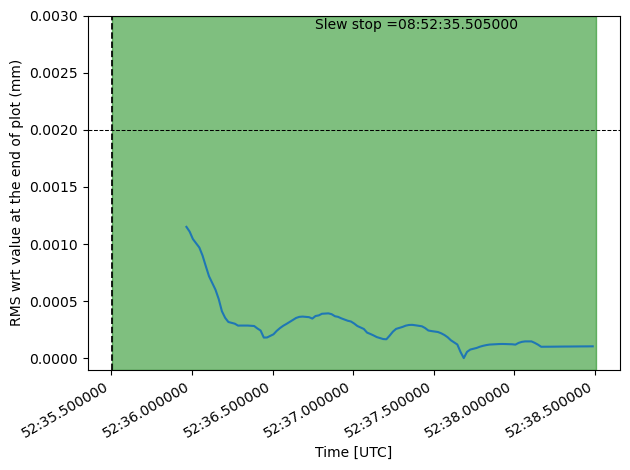

In [21]:
%matplotlib inline
determineSettleTime(df_ims = df_ims, 
                    reference_t = t1, 
                    lo_delta_t = 5,
                    hi_delta_t = postPadding,
                    imsColumn = 'xPosition', 
                    rmsReq = req_rms_position, 
                    req_delta_t = req_delta_t,
                    lapse = 600, pvalue = 0.001)

index at T1 105
Test PASSED
index at T1 105
Test PASSED
index at T1 105
Test PASSED
index at T1 105
Test PASSED
index at T1 105
Test PASSED
index at T1 105
Test PASSED
index at T1 105
Test PASSED
index at T1 105
Test PASSED
index at T1 105
Test PASSED
index at T1 105
Test PASSED
index at T1 105
Test PASSED
index at T1 105
Test PASSED
index at T1 105
Test PASSED
index at T1 105
Test PASSED
index at T1 105
Test PASSED


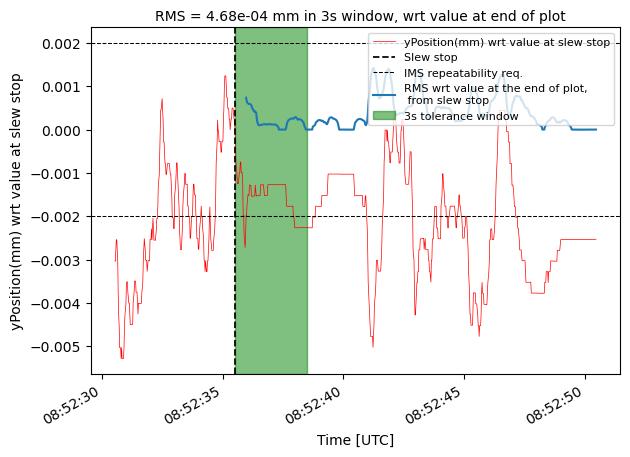

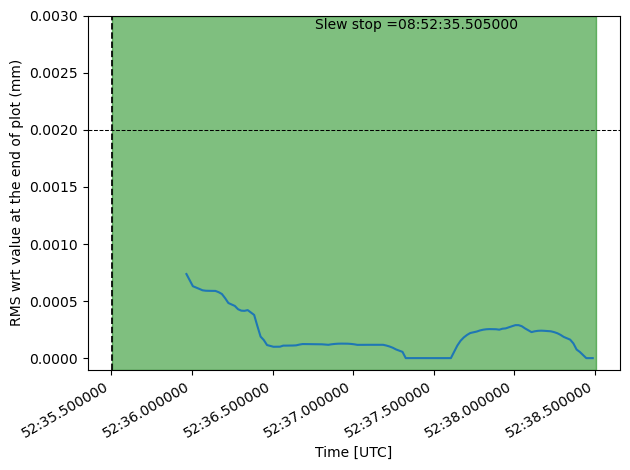

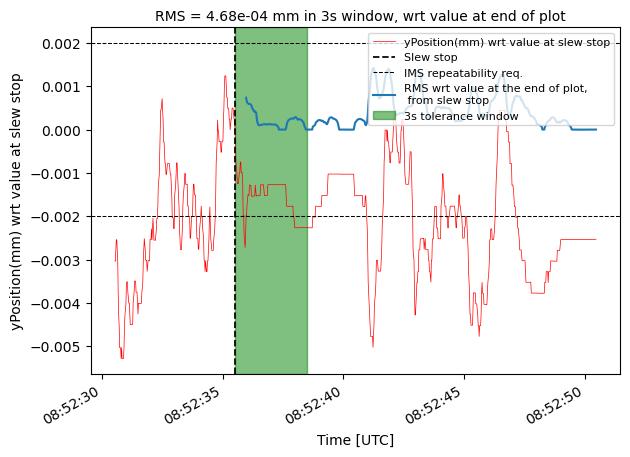

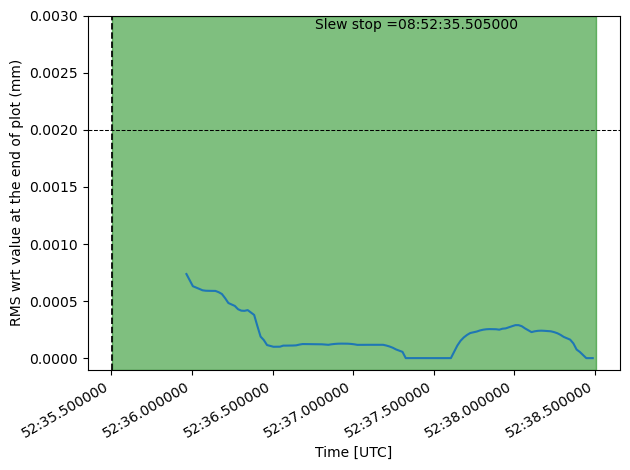

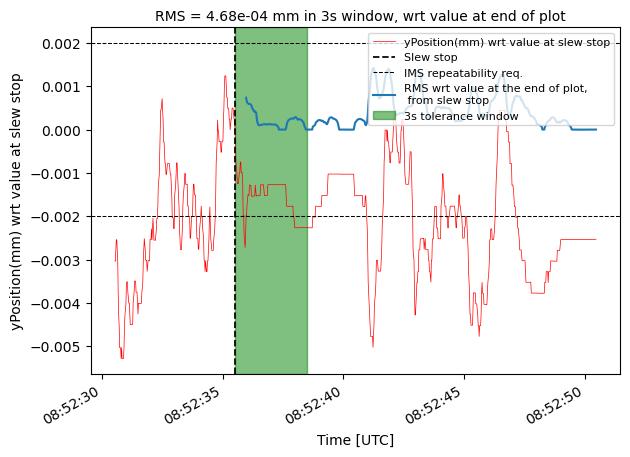

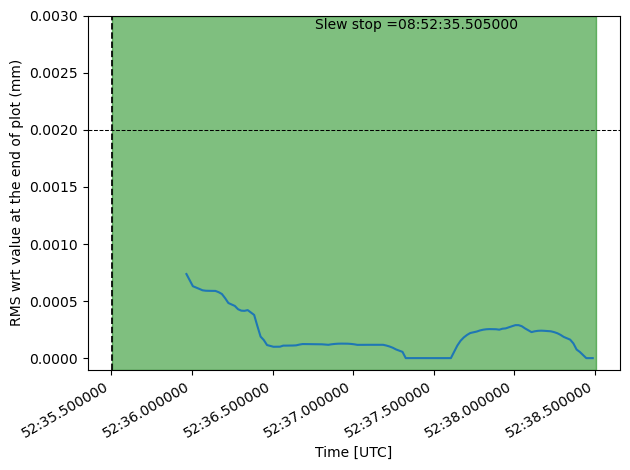

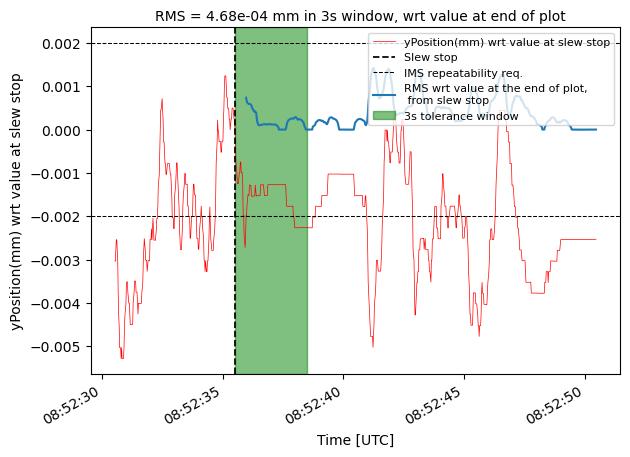

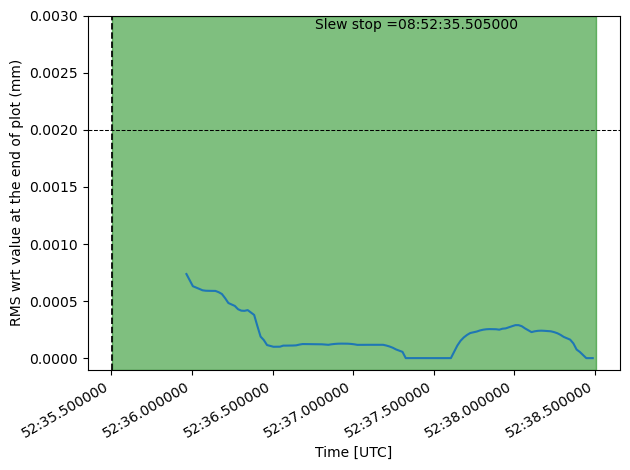

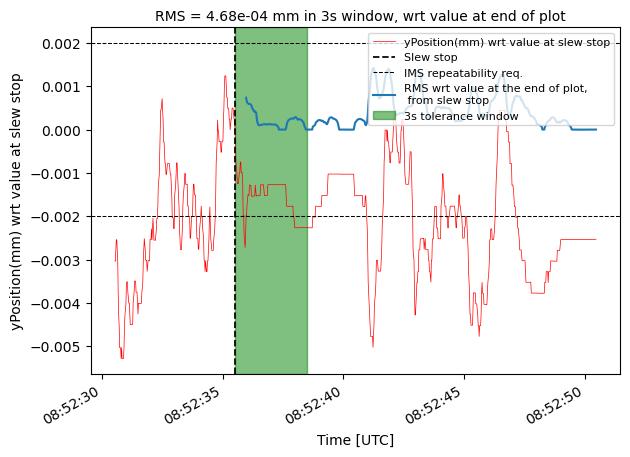

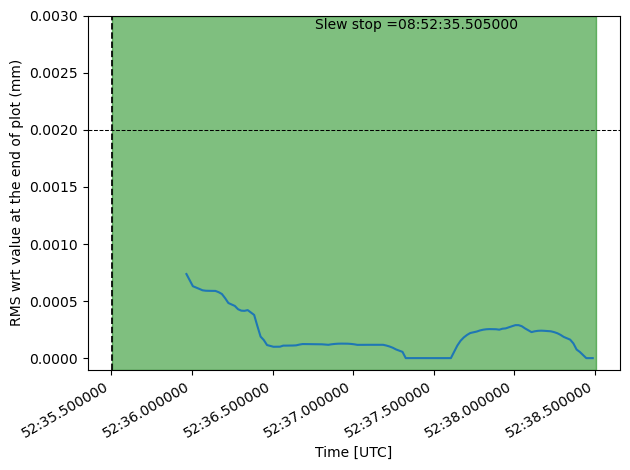

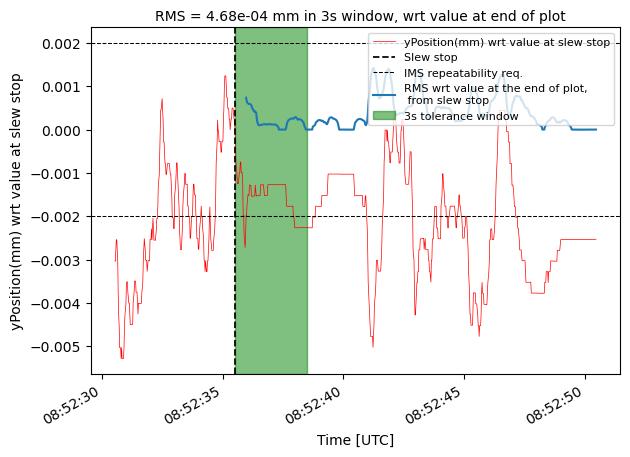

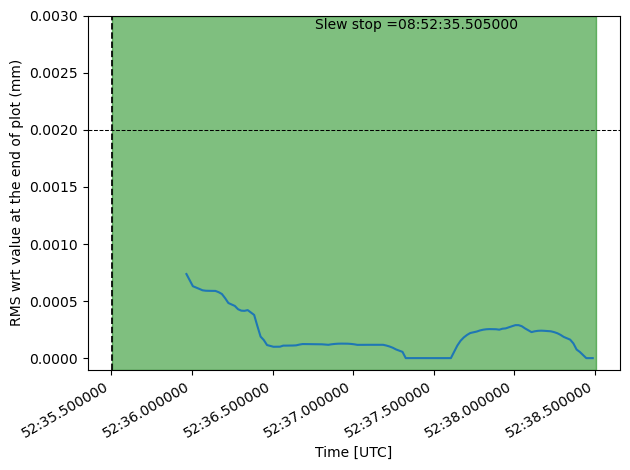

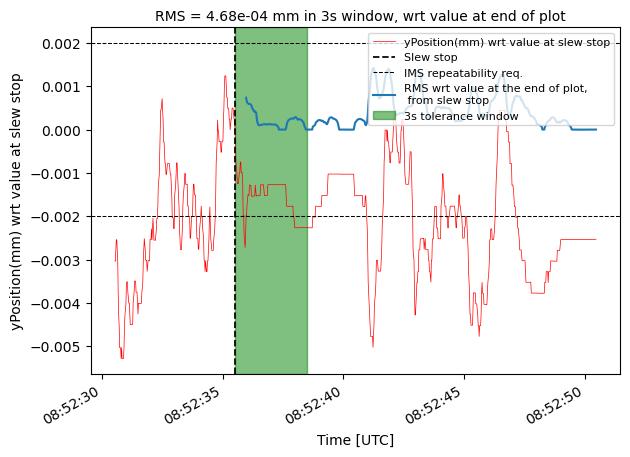

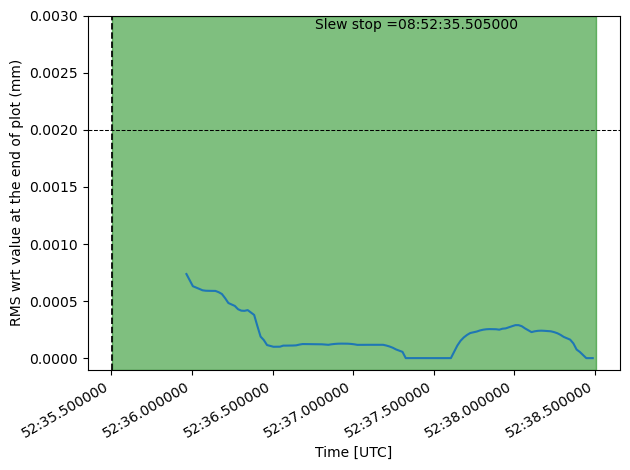

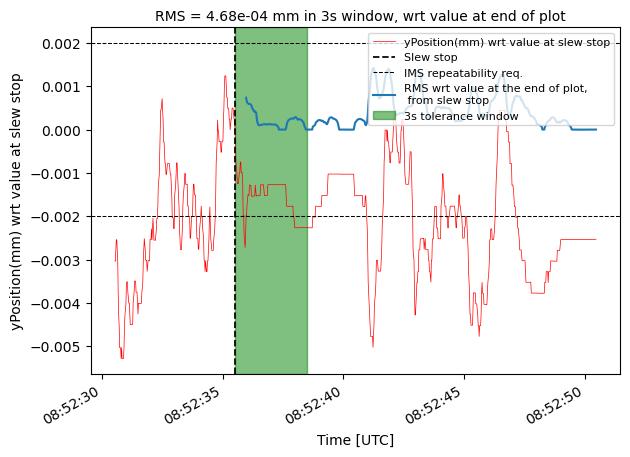

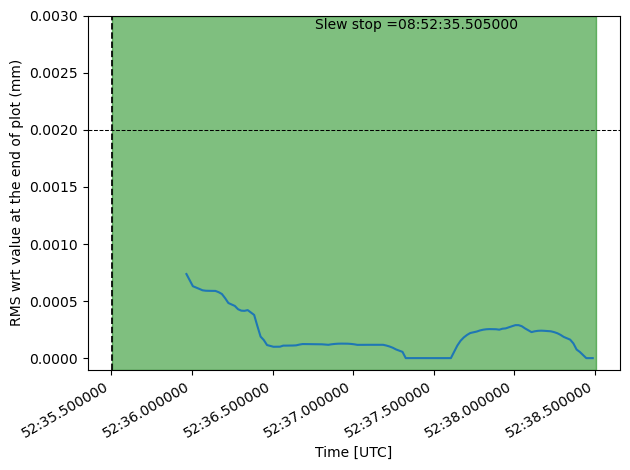

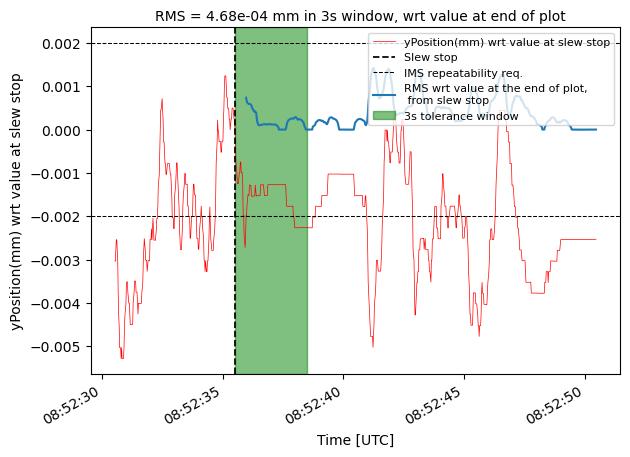

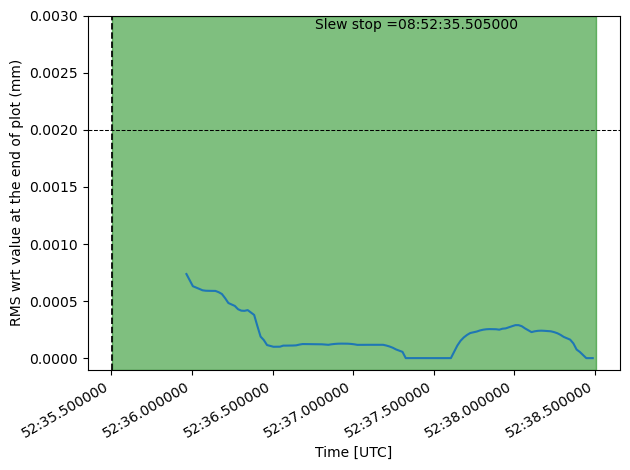

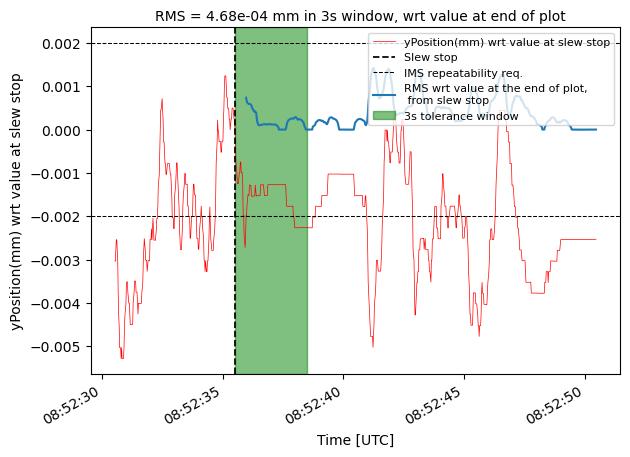

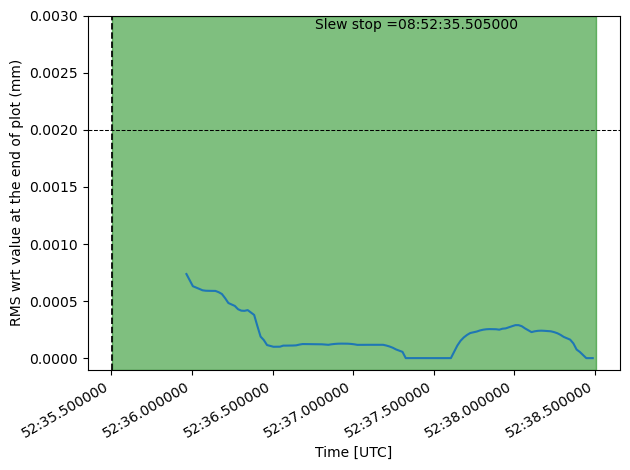

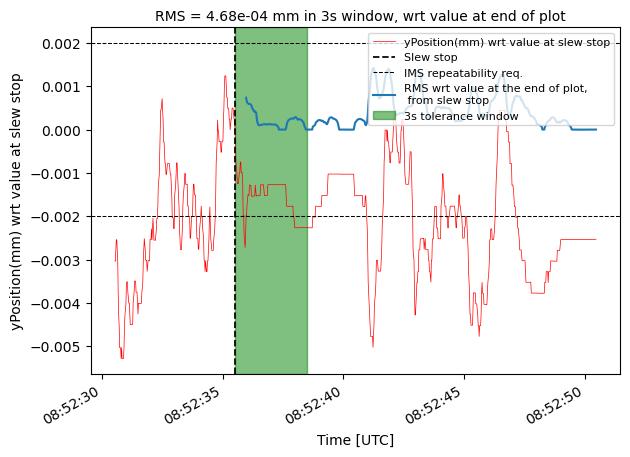

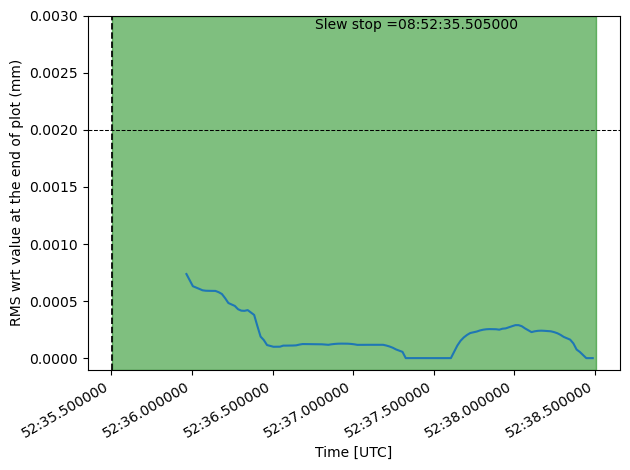

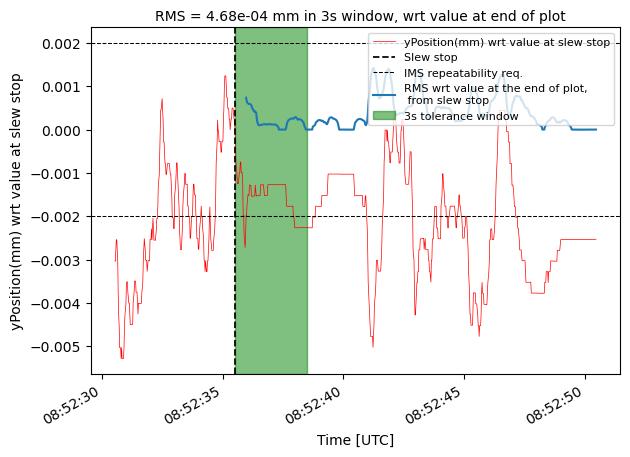

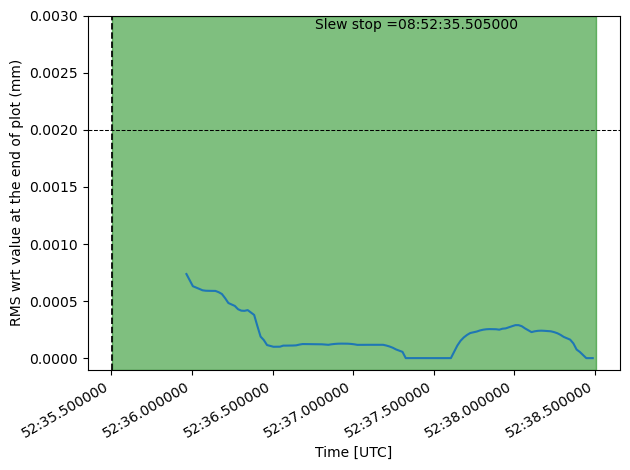

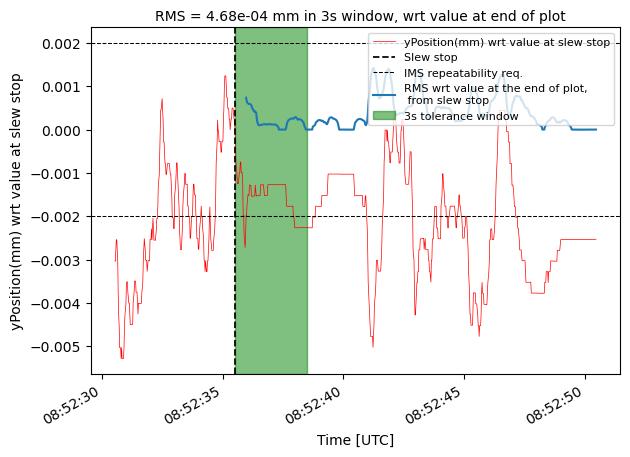

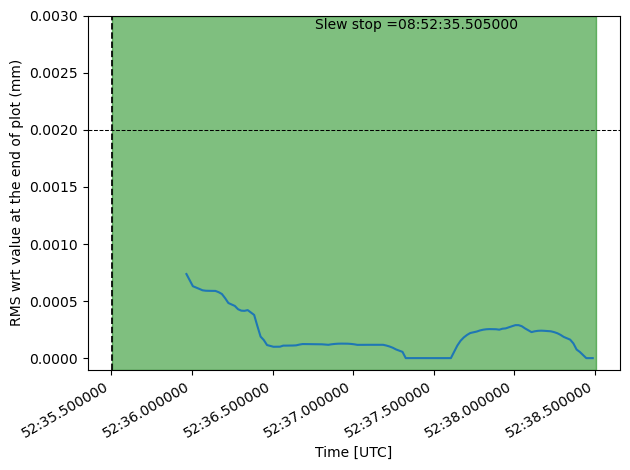

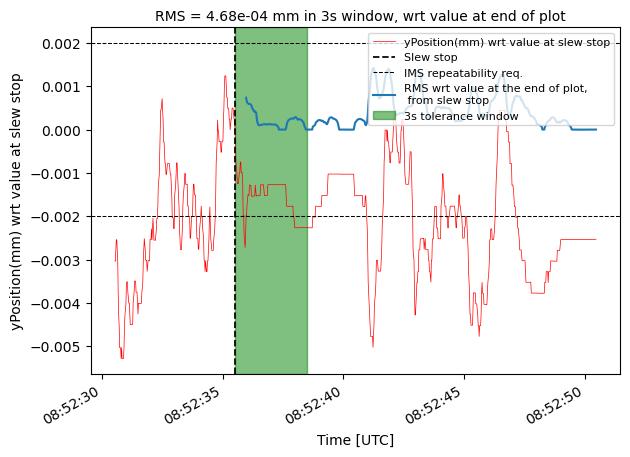

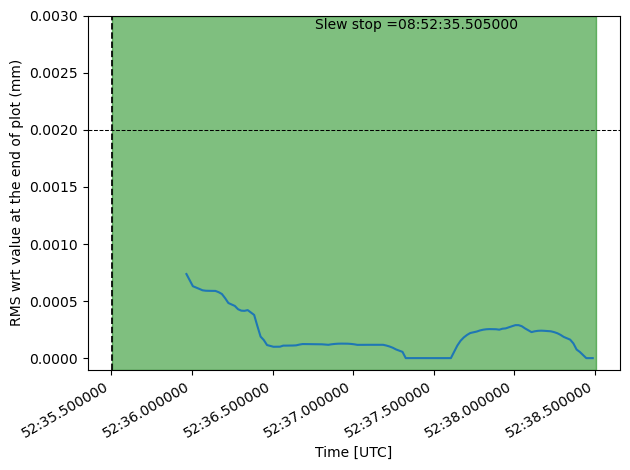

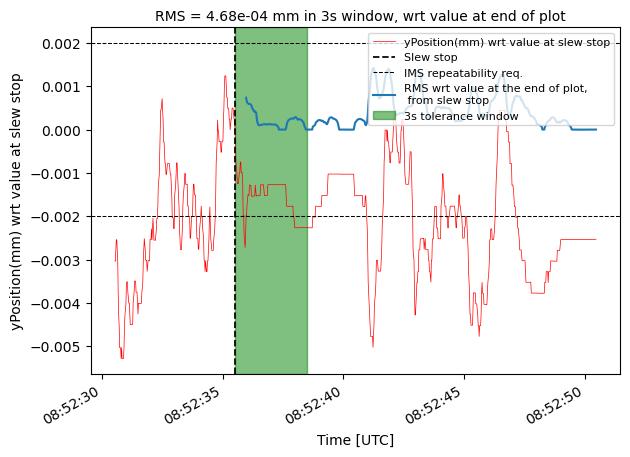

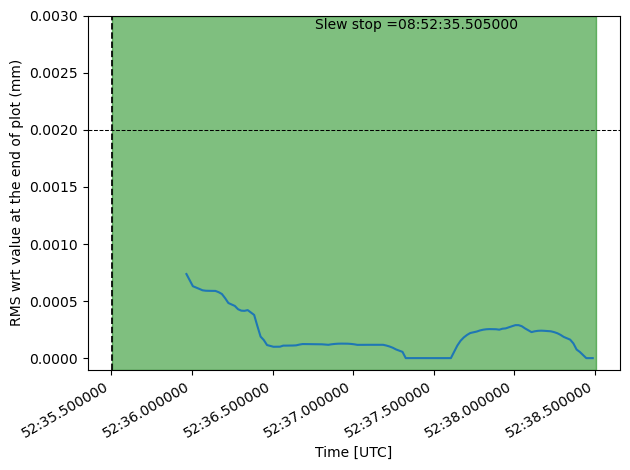

In [22]:
for i in [10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100, 200, 300, 600, 900]:
    #check stability of result (settle time) for several lapse (i) values
    determineSettleTime(df_ims = df_ims, 
                    reference_t = t1, 
                    lo_delta_t = 5,
                    hi_delta_t = 60,
                    imsColumn = 'yPosition', 
                    rmsReq = req_rms_position, 
                    req_delta_t = req_delta_t,
                    lapse = i, pvalue = 0.001)
    ##print(settle)